# Dataton : COVID-19 infection dataset을 통한 insight 도출

## 코로나 데이터 분석
> **사회적 거리두기**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
path = './dataset/'

case = p_info = pd.read_csv(path+'Case.csv')
p_info = pd.read_csv(path+'PatientInfo.csv')
#p_route = pd.read_csv(path+'PatientRoute.csv')
time = pd.read_csv(path+'Time.csv')
t_age = pd.read_csv(path+'TimeAge.csv')
t_gender = pd.read_csv(path+'TimeGender.csv')
t_provin = pd.read_csv(path+'TimeProvince.csv')
region = pd.read_csv(path+'Region.csv')
weather = pd.read_csv(path+'Weather.csv')
search = pd.read_csv(path+'SearchTrend.csv')
floating = pd.read_csv(path+'SeoulFloating.csv')
policy = pd.read_csv(path+'Policy.csv')

In [4]:
policy.head()

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN


In [5]:
time_sat = time.loc[[5+7*i for i in range(23)],:]
time_sat.head()

,date,time,test,negative,confirmed,released,deceased
5,2020-01-25,16,27,25,2,0,0
12,2020-02-01,16,371,289,12,0,0
19,2020-02-08,16,2097,1134,24,2,0
26,2020-02-15,16,7734,7148,28,9,0
33,2020-02-22,16,21586,15116,433,18,2


In [6]:
time_sun = time.loc[[6+7*i for i in range(23)],:]
time_sun.head()

,date,time,test,negative,confirmed,released,deceased
6,2020-01-26,16,51,47,3,0,0
13,2020-02-02,16,429,327,15,0,0
20,2020-02-09,16,2598,1683,27,3,0
27,2020-02-16,16,8161,7647,29,9,0
34,2020-02-23,16,26179,17520,602,18,6


In [7]:
time_weekend = time_sat.append(time_sun)
time_weekend = time_weekend.sort_index()
time_weekend.head(12)

,date,time,test,negative,confirmed,released,deceased
5,2020-01-25,16,27,25,2,0,0
6,2020-01-26,16,51,47,3,0,0
12,2020-02-01,16,371,289,12,0,0
13,2020-02-02,16,429,327,15,0,0
19,2020-02-08,16,2097,1134,24,2,0
20,2020-02-09,16,2598,1683,27,3,0
26,2020-02-15,16,7734,7148,28,9,0
27,2020-02-16,16,8161,7647,29,9,0
33,2020-02-22,16,21586,15116,433,18,2
34,2020-02-23,16,26179,17520,602,18,6


In [8]:
policy_SD = policy.loc[policy['gov_policy'] == 'Social Distancing Campaign',:]
policy_SD

,policy_id,country,type,gov_policy,detail,start_date,end_date
28,29,Korea,Social,Social Distancing Campaign,Strong,2020-02-29,2020-03-21
29,30,Korea,Social,Social Distancing Campaign,Strong,2020-03-22,2020-04-19
30,31,Korea,Social,Social Distancing Campaign,Weak,2020-04-20,2020-05-05
31,32,Korea,Social,Social Distancing Campaign,Weak(1st),2020-05-06,NaN


In [9]:
# 결측치 채우기
policy_SD['end_date'] = policy_SD['end_date'].fillna('2020-06-30')
policy_SD

<ipython-input-9-2b1d2b982346>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  policy_SD['end_date'] = policy_SD['end_date'].fillna('2020-06-30')


,policy_id,country,type,gov_policy,detail,start_date,end_date
28,29,Korea,Social,Social Distancing Campaign,Strong,2020-02-29,2020-03-21
29,30,Korea,Social,Social Distancing Campaign,Strong,2020-03-22,2020-04-19
30,31,Korea,Social,Social Distancing Campaign,Weak,2020-04-20,2020-05-05
31,32,Korea,Social,Social Distancing Campaign,Weak(1st),2020-05-06,2020-06-30


In [10]:
def mk_size(data, c):
    data_col  = data.groupby(c)
    data_size = data_col.size().to_frame()
    data_size.columns = ['counts']
    data_size = data_size.reset_index().rename(columns = {'index': c})

    return data_size


def plt_pie(data,c):
    fig = plt.figure(figsize = (8,8))
    fig.set_facecolor('w')
    
    plt.pie(data['counts'],
        labels = data[c], 
        autopct='%.1f%%',explode = [0.05]*len(data), 
        wedgeprops = {'width': 0.3, 'edgecolor': 'w', 'linewidth': 1})
    
    plt.show()

In [11]:
p_age  = p_info.groupby('age')
p_age_size = p_age.size()

p_age_size = p_age_size.to_frame()
p_age_size.columns = ['counts']
p_age_size = p_age_size.reset_index().rename(columns = {'index': 'age'})
p_age_size

,age,counts
0,0s,66
1,100s,1
2,10s,178
3,20s,899
4,30s,523
5,40s,518
6,50s,667
7,60s,482
8,70s,232
9,80s,170


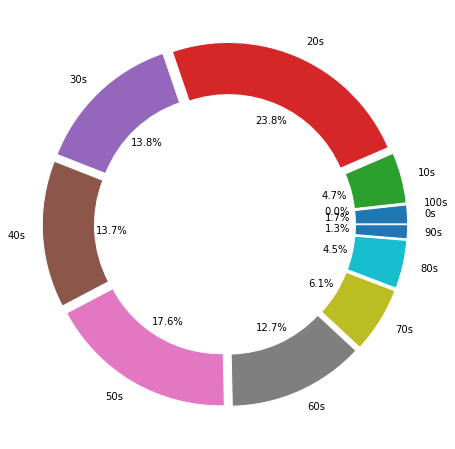

In [12]:
fig = plt.figure(figsize = (8,8))
fig.set_facecolor('w')

# ax = fig.add_subplot()
plt.pie(p_age_size['counts'], 
        labels = p_age_size['age'], 
        autopct='%.1f%%',explode = [0.05]*11, 
        wedgeprops = {'width': 0.3, 'edgecolor': 'w', 'linewidth': 1})
plt.show()

In [13]:
# province
region_pv = region.groupby('province')
region_pv_size = region_pv.size().to_frame()
region_pv_size.columns = ['counts']
region_pv_size = region_pv_size.reset_index().rename(columns = {'index': 'province'})
region_pv_size = region_pv_size.drop([14])

region_pv_size.head()

,province,counts
0,Busan,17
1,Chungcheongbuk-do,12
2,Chungcheongnam-do,16
3,Daegu,9
4,Daejeon,6


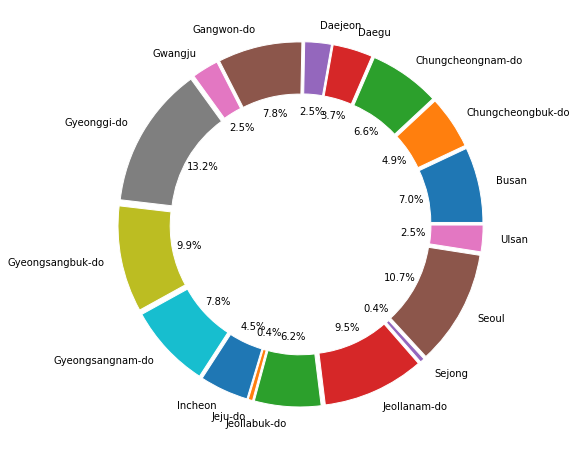

In [14]:
fig = plt.figure(figsize = (8,8))
fig.set_facecolor('w')

# ax = fig.add_subplot()
plt.pie(region_pv_size['counts'],
        labels = region_pv_size['province'], 
        autopct='%.1f%%',explode = [0.05]*len(region_pv_size), 
        wedgeprops = {'width': 0.3, 'edgecolor': 'w', 'linewidth': 1})
plt.show()

In [15]:
p_sex = mk_size(p_info,'sex')
p_sex.head()

,sex,counts
0,female,2218
1,male,1825


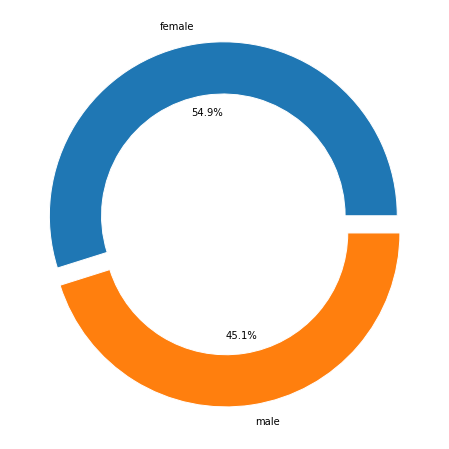

In [16]:
plt_pie(p_sex,'sex')

In [17]:
policy_gov = mk_size(policy,'gov_policy')
policy_gov.head()

,gov_policy,counts
0,Close bars and clubs,1
1,Close karaoke,1
2,Drive-Through Screening Center,2
3,Electronic Wristbands,1
4,Emergency Use Authorization of Diagnostic Kit,5


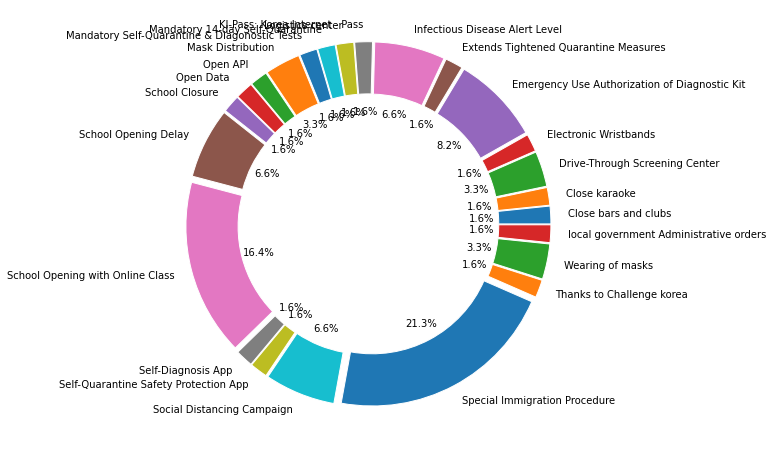

In [18]:
plt_pie(policy_gov, 'gov_policy')

In [19]:
start_date = ['2020-01-20','2020-02-29','2020-03-22','2020-04-20','2020-05-06']

for i, s in zip(range(5), start_date):
    globals()['t_start_{}'.format(i)] = time.loc[time['date'] == s,:]

t_start = pd.concat([t_start_0,t_start_1,t_start_2,t_start_3,t_start_4])
t_start

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
40,2020-02-29,16,94055,55723,3150,28,17
62,2020-03-22,0,331780,308343,8897,2909,104
91,2020-04-20,0,563035,540380,10674,8114,236
107,2020-05-06,0,643095,624280,10806,9333,255


In [20]:
# wknd = time_weekend['date'].values.tolist()
# tp_sg_wknd = timeprvc_sg[timeprvc_sg['date'].isin(wknd)]

# tp_sg_wknd

In [21]:
start_idx = []
for s in start_date:
    start_idx.append(time.index[time['date'] == s].values.tolist()[0])
    
start_idx

[0, 40, 62, 91, 107]

In [22]:
# t0 = time[0:40+1]
# t1 = time[40:62+1]
# t2 = time[62:91+1]
# t3 = time[91:107+1]
# t4 = time[107:]

for i in range (4):
    globals()['t{}'.format(i)] = time[start_idx[i]:start_idx[i+1]+1]
t4 = time[start_idx[-1]:]

t2.head()

,date,time,test,negative,confirmed,released,deceased
62,2020-03-22,0,331780,308343,8897,2909,104
63,2020-03-23,0,338036,315447,8961,3166,111
64,2020-03-24,0,348582,324105,9037,3507,120
65,2020-03-25,0,357896,334481,9137,3730,126
66,2020-03-26,0,364942,341332,9241,4144,131


In [23]:
for i in range(121):
    for j in range(9):
        globals()['t_age_{}'.format(j)] = t_age.loc[[j+9*i for i in range(121)],:].reset_index()

In [24]:
t_age_1.head()

,index,date,time,age,confirmed,deceased
0,1,2020-03-02,0,10s,169,0
1,10,2020-03-03,0,10s,204,0
2,19,2020-03-04,0,10s,233,0
3,28,2020-03-05,0,10s,257,0
4,37,2020-03-06,0,10s,292,0


In [25]:
# 일일 확진자 수
daily = time.astype({'confirmed':'int'})
daily['daily'] = daily['confirmed'].diff().fillna(0)

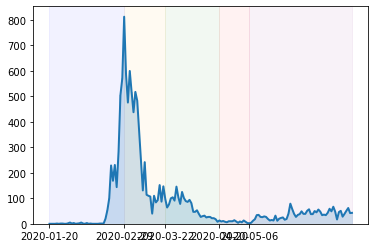

In [26]:
fig1, ax1 = plt.subplots()

ax1.axvspan(0,40, alpha = 0.05, color = 'blue')
ax1.axvspan(40,62, alpha = 0.05, color = 'orange')
ax1.axvspan(62,91, alpha = 0.05, color = 'green')
ax1.axvspan(91,107, alpha = 0.05, color = 'red')
ax1.axvspan(107,162, alpha = 0.05, color = 'purple')

plt.rcParams["figure.figsize"] = (12,5)
plt.plot(daily['date'],daily['daily'], linewidth = 2.0)
plt.bar(daily['date'],daily['daily'], width = 1.0, alpha = 0.2)
plt.xticks(start_date)
plt.show()

In [27]:
time_age_date = time[42:]
time_age_date = time_age_date.reset_index()
time_age_date.head()

,index,date,time,test,negative,confirmed,released,deceased
0,42,2020-03-02,0,109591,71580,4212,31,22
1,43,2020-03-03,0,125851,85484,4812,34,28
2,44,2020-03-04,0,136707,102965,5328,41,32
3,45,2020-03-05,0,146541,118965,5766,88,35
4,46,2020-03-06,0,164740,136624,6284,108,42


In [28]:
# t_age_start0 = time_age_date.loc[time_age_date['date'] == '2020-01-20',:]
# t_age_start1 = time_age_date.loc[time_age_date['date'] == '2020-02-29',:]
t_age_start2 = time_age_date.loc[time_age_date['date'] == '2020-03-22',:]
t_age_start3 = time_age_date.loc[time_age_date['date'] == '2020-04-20',:]
t_age_start4 = time_age_date.loc[time_age_date['date'] == '2020-05-06',:]


t_age_start = pd.concat([t_age_start2,t_age_start3,t_age_start4])
t_age_start

,index,date,time,test,negative,confirmed,released,deceased
20,62,2020-03-22,0,331780,308343,8897,2909,104
49,91,2020-04-20,0,563035,540380,10674,8114,236
65,107,2020-05-06,0,643095,624280,10806,9333,255


In [29]:
for i in range(121):
    for j in range(9):
        globals()['t_age_{}'.format(j)] = t_age.loc[[j+9*i for i in range(121)],:]

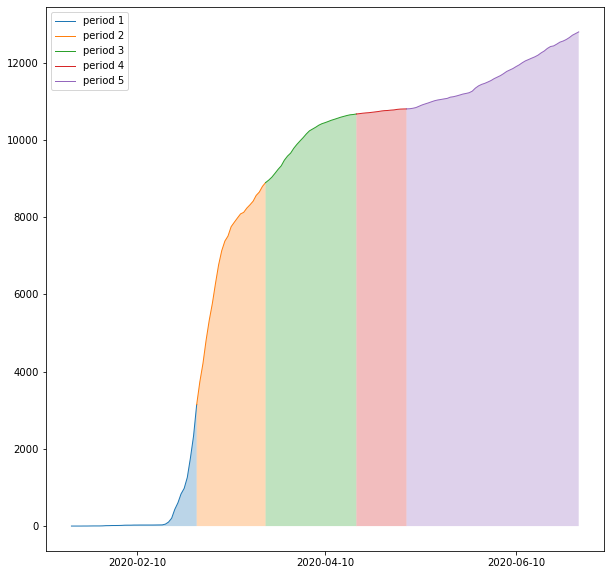

In [30]:
# 누적 확진자 수
for i in range(5):
    df = globals()['t{}'.format(i)]
    plt.rcParams["figure.figsize"] = (10,10)
    plt.plot(df['date'], df['confirmed'], label = 'period {}'.format(i+1), linewidth = '1.0')
    
    plt.fill_between(df['date'],df['confirmed'], alpha = 0.3)
    
    plt.legend()
    
plt.xticks(['2020-02-10','2020-04-10','2020-06-10'])
plt.show()

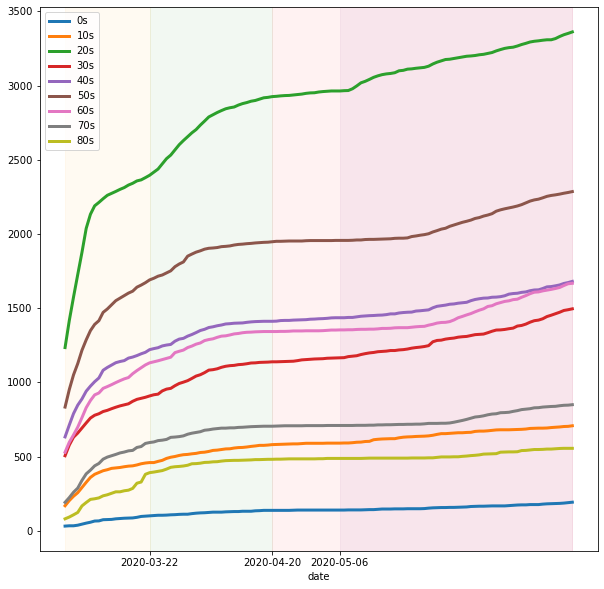

In [31]:
# 사회적 거리두기 단계별 연령대별 확진자 수
fig, ax = plt.subplots()

for i in range(9):
    df = globals()['t_age_{}'.format(i)]
    plt.rcParams["figure.figsize"] = (10,10)
    plt.plot(df['date'], df['confirmed'], label = '{}s'.format(i*10), linewidth = 3.0)
    plt.xlabel('date')
    plt.legend()


ax.axvspan(0,20, alpha = 0.05, color = 'orange')
ax.axvspan(20,49, alpha = 0.05, color = 'green')
ax.axvspan(49,120, alpha = 0.05, color = 'red')
ax.axvspan(65,120, alpha = 0.05, color = 'purple')
plt.xticks(start_date[2:])
plt.show()

> **자영업 통제**<br>정부의 자영업 통제 관련 시책의 실효성을 검증해보기 위한 데이터 분석 시작. 정책 관련 데이터인 policy.csv에서 내가 검증해보고자 하는 administrative colomn의 내용을 선별 후, 해당 시책이 영향을 미쳤을 것으로 사료되는 다른 data의 요소들을 찾아 감염수치를 판단할 수 있는 형태로 데이터 재구성. 마지막으로 전체적인 혹은 영향이 미비할 것으로 판단되는 타 data와의 비교 · 분석을 통해 시책의 실효성을 판단해보기로함.

## Data preprocessing

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
case = pd.read_csv('./dataset/Case.csv')
time = pd.read_csv('./dataset/Time.csv')
timeage = pd.read_csv('./dataset/TimeAge.csv')
timeprvc = pd.read_csv('./dataset/TimeProvince.csv')
region = pd.read_csv('./dataset/Region.csv')
policy = pd.read_csv('./dataset/Policy.csv')
patient = pd.read_csv('./dataset/PatientInfo.csv')

### 1. policy.csv에서 내가 검토해보고자 하는 administrative의 내용 추출

In [4]:
pol = policy

In [5]:
pol.head()

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN


In [6]:
pol['country'].unique()

array(['Korea'], dtype=object)

In [7]:
pol = pol.drop('country',axis=1)

In [8]:
pol_admin = pol[pol['type'] == 'Administrative']
pol_admin = pol_admin.fillna('2020-06-30') ## end-date 결측치의 경우 지속되고 있는 정책으로 판단. 20년도 기준 데이터이기 때문에 20년도 말까지 진행된 것으로 수정

pol_admin

,policy_id,type,gov_policy,detail,start_date,end_date
53,54,Administrative,Close bars and clubs,administrative order to close bars and clubs,2020-05-08,2020-06-07
54,55,Administrative,local government Administrative orders,Gathering limited administrative orders for nu...,2020-05-16,2020-06-30
55,56,Administrative,Close karaoke,Ban on gathering for 2 weeks for all karaoke a...,2020-05-21,2020-06-03


In [9]:
region

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080
...,...,...,...,...,...,...,...,...,...,...,...,...
239,61160,Gyeongsangnam-do,Haman-gun,35.272481,128.406540,16,20,0,1.19,23.74,14.7,94
240,61170,Gyeongsangnam-do,Hamyang-gun,35.520541,127.725177,13,12,0,1.01,32.65,20.9,83
241,61180,Gyeongsangnam-do,Hapcheon-gun,35.566702,128.165870,17,15,0,0.71,38.44,24.7,96
242,70000,Jeju-do,Jeju-do,33.488936,126.500423,113,123,4,1.53,15.10,6.4,1245


In [10]:
region = region.iloc[:,[1,2,7]]

region_seoul = region.loc[region['province'] == 'Seoul',:]
region_gyeonggi = region.loc[region['province'] == 'Gyeonggi-do',:]

region = region_seoul.append(region_gyeonggi)

In [11]:
region = region.sort_values(by='university_count', axis=0, ascending=False)

region

,province,city,university_count
82,Gyeonggi-do,Gyeonggi-do,61
0,Seoul,Seoul,48
105,Gyeonggi-do,Yongin-si,7
9,Seoul,Nowon-gu,6
17,Seoul,Seongbuk-gu,6
14,Seoul,Seodaemun-gu,6
113,Gyeonggi-do,Hwaseong-si,6
99,Gyeonggi-do,Anyang-si,4
95,Gyeonggi-do,Suwon-si,4
11,Seoul,Dongdaemun-gu,4


In [12]:
# 토요일 데이터
time_sat = time.loc[[5+7*i for i in range(23)],:]
time_sat

,date,time,test,negative,confirmed,released,deceased
5,2020-01-25,16,27,25,2,0,0
12,2020-02-01,16,371,289,12,0,0
19,2020-02-08,16,2097,1134,24,2,0
26,2020-02-15,16,7734,7148,28,9,0
33,2020-02-22,16,21586,15116,433,18,2
40,2020-02-29,16,94055,55723,3150,28,17
47,2020-03-07,0,178189,151802,6767,118,44
54,2020-03-14,0,261335,235615,8086,714,72
61,2020-03-21,0,327509,303006,8799,2612,102
68,2020-03-28,0,387925,361883,9478,4811,144


In [13]:
# 일요일 데이터
time_sun = time.loc[[6+7*i for i in range(23)],:]
time_sun

,date,time,test,negative,confirmed,released,deceased
6,2020-01-26,16,51,47,3,0,0
13,2020-02-02,16,429,327,15,0,0
20,2020-02-09,16,2598,1683,27,3,0
27,2020-02-16,16,8161,7647,29,9,0
34,2020-02-23,16,26179,17520,602,18,6
41,2020-03-01,16,98921,61825,3736,30,18
48,2020-03-08,0,188518,162008,7134,130,50
55,2020-03-15,0,268212,243778,8126,834,75
62,2020-03-22,0,331780,308343,8897,2909,104
69,2020-03-29,0,394141,369530,9583,5033,152


In [14]:
# 데이터 병합
time_weekend = time_sat.append(time_sun)
time_weekend = time_weekend.sort_index()
time_weekend.head(12)

,date,time,test,negative,confirmed,released,deceased
5,2020-01-25,16,27,25,2,0,0
6,2020-01-26,16,51,47,3,0,0
12,2020-02-01,16,371,289,12,0,0
13,2020-02-02,16,429,327,15,0,0
19,2020-02-08,16,2097,1134,24,2,0
20,2020-02-09,16,2598,1683,27,3,0
26,2020-02-15,16,7734,7148,28,9,0
27,2020-02-16,16,8161,7647,29,9,0
33,2020-02-22,16,21586,15116,433,18,2
34,2020-02-23,16,26179,17520,602,18,6


In [15]:
case.tail()

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
169,6100012,Gyeongsangnam-do,-,False,etc,20,-,-
170,7000001,Jeju-do,-,False,overseas inflow,14,-,-
171,7000002,Jeju-do,-,False,contact with patient,0,-,-
172,7000003,Jeju-do,-,False,etc,4,-,-
173,7000004,Jeju-do,from other city,True,Itaewon Clubs,1,-,-


In [16]:
# case_seoul  = case[case['province'] == 'Seoul']
# case_gyeonggi = case[case['province'] == 'Gyeonggi-do']

# case = case_gyeonggi.append(case_seoul)

# case.sort_index()

In [17]:
patient.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [18]:
col_use = ['patient_id', 'province', 'city', 'contact_number', 'confirmed_date']
patient[col_use]

,patient_id,province,city,contact_number,confirmed_date
0,1000000001,Seoul,Gangseo-gu,75,2020-01-23
1,1000000002,Seoul,Jungnang-gu,31,2020-01-30
2,1000000003,Seoul,Jongno-gu,17,2020-01-30
3,1000000004,Seoul,Mapo-gu,9,2020-01-30
4,1000000005,Seoul,Seongbuk-gu,2,2020-01-31
...,...,...,...,...,...
5160,7000000015,Jeju-do,Jeju-do,25,2020-05-30
5161,7000000016,Jeju-do,Jeju-do,NaN,2020-06-16
5162,7000000017,Jeju-do,Jeju-do,72,2020-06-18
5163,7000000018,Jeju-do,Jeju-do,NaN,2020-06-18


In [19]:
timeprvc.tail()

,date,time,province,confirmed,released,deceased
2766,2020-06-30,0,Jeollabuk-do,27,21,0
2767,2020-06-30,0,Jeollanam-do,24,19,0
2768,2020-06-30,0,Gyeongsangbuk-do,1389,1328,54
2769,2020-06-30,0,Gyeongsangnam-do,134,128,0
2770,2020-06-30,0,Jeju-do,19,16,0


In [20]:
timeprvc['time'].unique()

array([16,  0], dtype=int64)

In [21]:
timeprvc[timeprvc['time'] == 16]

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0
...,...,...,...,...,...,...
709,2020-03-01,16,Jeollabuk-do,6,1,0
710,2020-03-01,16,Jeollanam-do,3,0,0
711,2020-03-01,16,Gyeongsangbuk-do,556,1,6
712,2020-03-01,16,Gyeongsangnam-do,63,1,0


In [22]:
timeprvc_seoul = timeprvc.loc[timeprvc['province'] == 'Seoul',:]
timeprvc_gyeonggi = timeprvc.loc[timeprvc['province'] == 'Gyeonggi-do',:]
timeprvc_sg = timeprvc_seoul.append(timeprvc_gyeonggi)

timeprvc_sg.tail()

,date,time,province,confirmed,released,deceased
2694,2020-06-26,0,Gyeonggi-do,1150,814,23
2711,2020-06-27,0,Gyeonggi-do,1167,858,22
2728,2020-06-28,0,Gyeonggi-do,1184,873,23
2745,2020-06-29,0,Gyeonggi-do,1200,888,23
2762,2020-06-30,0,Gyeonggi-do,1207,931,23


In [23]:
timeprvc_sg.head()

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
17,2020-01-21,16,Seoul,0,0,0
34,2020-01-22,16,Seoul,0,0,0
51,2020-01-23,16,Seoul,0,0,0
68,2020-01-24,16,Seoul,0,0,0


In [24]:
wknd = time_weekend['date'].values.tolist()
tp_sg_wknd = timeprvc_sg[timeprvc_sg['date'].isin(wknd)]

tp_sg_wknd

,date,time,province,confirmed,released,deceased
85,2020-01-25,16,Seoul,0,0,0
102,2020-01-26,16,Seoul,0,0,0
204,2020-02-01,16,Seoul,4,0,0
221,2020-02-02,16,Seoul,5,0,0
323,2020-02-08,16,Seoul,11,1,0
...,...,...,...,...,...,...
2490,2020-06-14,0,Gyeonggi-do,1035,710,22
2592,2020-06-20,0,Gyeonggi-do,1107,741,22
2609,2020-06-21,0,Gyeonggi-do,1117,744,22
2711,2020-06-27,0,Gyeonggi-do,1167,858,22


In [25]:
tp_all_wknd = timeprvc[timeprvc['date'].isin(wknd)]

tp_all_wknd

,date,time,province,confirmed,released,deceased
85,2020-01-25,16,Seoul,0,0,0
86,2020-01-25,16,Busan,0,0,0
87,2020-01-25,16,Daegu,0,0,0
88,2020-01-25,16,Incheon,1,0,0
89,2020-01-25,16,Gwangju,0,0,0
...,...,...,...,...,...,...
2732,2020-06-28,0,Jeollabuk-do,26,21,0
2733,2020-06-28,0,Jeollanam-do,23,19,0
2734,2020-06-28,0,Gyeongsangbuk-do,1387,1328,54
2735,2020-06-28,0,Gyeongsangnam-do,133,128,0


In [26]:
s_idx = timeprvc[timeprvc['province'] == 'Seoul'].index
g_idx = timeprvc[timeprvc['province'] == 'Gyeonggi-do'].index

s_idx

Int64Index([   0,   17,   34,   51,   68,   85,  102,  119,  136,  153,
            ...
            2601, 2618, 2635, 2652, 2669, 2686, 2703, 2720, 2737, 2754],
           dtype='int64', length=163)

In [27]:
tp_other = timeprvc.drop(s_idx)
tp_other = tp_other.drop(g_idx)

tp_other

,date,time,province,confirmed,released,deceased
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0
5,2020-01-20,16,Daejeon,0,0,0
...,...,...,...,...,...,...
2766,2020-06-30,0,Jeollabuk-do,27,21,0
2767,2020-06-30,0,Jeollanam-do,24,19,0
2768,2020-06-30,0,Gyeongsangbuk-do,1389,1328,54
2769,2020-06-30,0,Gyeongsangnam-do,134,128,0


In [28]:
tp_other['province'].unique()

array(['Busan', 'Daegu', 'Incheon', 'Gwangju', 'Daejeon', 'Ulsan',
       'Sejong', 'Gangwon-do', 'Chungcheongbuk-do', 'Chungcheongnam-do',
       'Jeollabuk-do', 'Jeollanam-do', 'Gyeongsangbuk-do',
       'Gyeongsangnam-do', 'Jeju-do'], dtype=object)

<AxesSubplot:xlabel='date', ylabel='confirmed'>

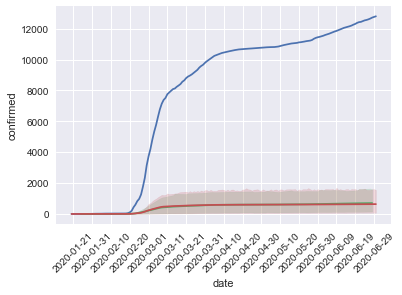

In [29]:
plt.xticks(np.arange(1,1000, step=10), rotation=45)

sns.lineplot(x='date', y='confirmed', data=time)
sns.lineplot(x='date', y='confirmed', data=tp_all_wknd)
sns.lineplot(x='date', y='confirmed', data=tp_other)

In [30]:
time.tail()

,date,time,test,negative,confirmed,released,deceased
158,2020-06-26,0,1232315,1200885,12602,11172,282
159,2020-06-27,0,1243780,1211261,12653,11317,282
160,2020-06-28,0,1251695,1219975,12715,11364,282
161,2020-06-29,0,1259954,1228698,12757,11429,282
162,2020-06-30,0,1273766,1240157,12800,11537,282


In [32]:
# 일일 확진자 수
time_daily = time.astype({'confirmed':'int'})
time_daily['daily'] = time_daily['confirmed'].diff().fillna(0)
time_daily

,date,time,test,negative,confirmed,released,deceased,daily
0,2020-01-20,16,1,0,1,0,0,0.0
1,2020-01-21,16,1,0,1,0,0,0.0
2,2020-01-22,16,4,3,1,0,0,0.0
3,2020-01-23,16,22,21,1,0,0,0.0
4,2020-01-24,16,27,25,2,0,0,1.0
...,...,...,...,...,...,...,...,...
158,2020-06-26,0,1232315,1200885,12602,11172,282,39.0
159,2020-06-27,0,1243780,1211261,12653,11317,282,51.0
160,2020-06-28,0,1251695,1219975,12715,11364,282,62.0
161,2020-06-29,0,1259954,1228698,12757,11429,282,42.0


In [33]:
wkd_daily_sat = time_daily.loc[[5+7*i for i in range(23)],:]
wkd_daily_sat.head()

wkd_daily_sun = time_daily.loc[[6+7*i for i in range(23)],:]
wkd_daily_sun.head()

,date,time,test,negative,confirmed,released,deceased,daily
6,2020-01-26,16,51,47,3,0,0,1.0
13,2020-02-02,16,429,327,15,0,0,3.0
20,2020-02-09,16,2598,1683,27,3,0,3.0
27,2020-02-16,16,8161,7647,29,9,0,1.0
34,2020-02-23,16,26179,17520,602,18,6,169.0


In [34]:
wkd_daily= wkd_daily_sat.append(wkd_daily_sun)
wkd_daily = wkd_daily.sort_index()
wkd_daily.head(12)

,date,time,test,negative,confirmed,released,deceased,daily
5,2020-01-25,16,27,25,2,0,0,0.0
6,2020-01-26,16,51,47,3,0,0,1.0
12,2020-02-01,16,371,289,12,0,0,1.0
13,2020-02-02,16,429,327,15,0,0,3.0
19,2020-02-08,16,2097,1134,24,2,0,0.0
20,2020-02-09,16,2598,1683,27,3,0,3.0
26,2020-02-15,16,7734,7148,28,9,0,0.0
27,2020-02-16,16,8161,7647,29,9,0,1.0
33,2020-02-22,16,21586,15116,433,18,2,229.0
34,2020-02-23,16,26179,17520,602,18,6,169.0


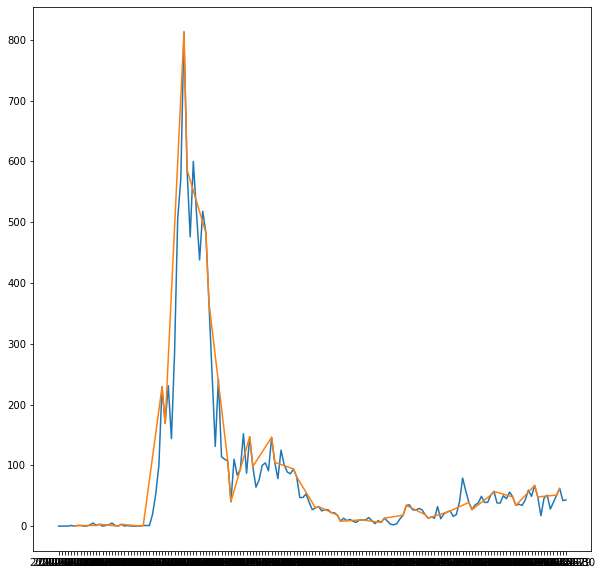

In [35]:
plt.plot(time_daily['date'], time_daily['daily'])
plt.plot(wkd_daily['date'], wkd_daily['daily'])

In [36]:
pv = mk_size(t_provin, 'province')

In [37]:
for i in range(163):
    for j in range(17):
        globals()['provin_t_{}'.format(j)] = t_provin.loc[[j+17*i for i in range(23)],:]
        
provin_t_0

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
17,2020-01-21,16,Seoul,0,0,0
34,2020-01-22,16,Seoul,0,0,0
51,2020-01-23,16,Seoul,0,0,0
68,2020-01-24,16,Seoul,0,0,0
85,2020-01-25,16,Seoul,0,0,0
102,2020-01-26,16,Seoul,0,0,0
119,2020-01-27,16,Seoul,1,0,0
136,2020-01-28,16,Seoul,1,0,0
153,2020-01-29,16,Seoul,1,0,0


In [38]:
for i in range(163):
    for j in range(17):
        # globals()['provin_t_{}'.format(j)] = t_provin.loc[[j+17*i for i in range(23)],:]
        t = t_provin.loc[[j+17*i for i in range(163)],:]
        t = t.astype({'confirmed':'int'})
        t['daily'] = t['confirmed'].diff().fillna(0)
        t = t.reset_index()
        globals()['p_daily_{}'.format(j)] = t

In [39]:
p_daily_0

,index,date,time,province,confirmed,released,deceased,daily
0,0,2020-01-20,16,Seoul,0,0,0,0.0
1,17,2020-01-21,16,Seoul,0,0,0,0.0
2,34,2020-01-22,16,Seoul,0,0,0,0.0
3,51,2020-01-23,16,Seoul,0,0,0,0.0
4,68,2020-01-24,16,Seoul,0,0,0,0.0
...,...,...,...,...,...,...,...,...
158,2686,2020-06-26,0,Seoul,1267,843,7,17.0
159,2703,2020-06-27,0,Seoul,1284,911,7,17.0
160,2720,2020-06-28,0,Seoul,1298,923,7,14.0
161,2737,2020-06-29,0,Seoul,1305,942,7,7.0


In [40]:
for j in range(17):
    s = globals()['p_daily_{}'.format(j)]
    
    p_sat = s.loc[[6+7*i for i in range(23)],:]
    p_sat.head()

    p_sun = s.loc[[7+7*i for i in range(23)],:]
    p_sun.head()
    
    p_wknd = p_sat.append(p_sun)
    p_wknd = p_wknd.sort_index()
    
    globals()['p_wknd_{}'.format(j)] = p_wknd.reset_index()

In [41]:
p_wknd_0.head()

,level_0,index,date,time,province,confirmed,released,deceased,daily
0,6,102,2020-01-26,16,Seoul,0,0,0,0.0
1,7,119,2020-01-27,16,Seoul,1,0,0,1.0
2,13,221,2020-02-02,16,Seoul,5,0,0,1.0
3,14,238,2020-02-03,16,Seoul,5,0,0,0.0
4,20,340,2020-02-09,16,Seoul,14,1,0,3.0


In [42]:
p_wknd_2.head()

,level_0,index,date,time,province,confirmed,released,deceased,daily
0,6,104,2020-01-26,16,Daegu,0,0,0,0.0
1,7,121,2020-01-27,16,Daegu,0,0,0,0.0
2,13,223,2020-02-02,16,Daegu,0,0,0,0.0
3,14,240,2020-02-03,16,Daegu,0,0,0,0.0
4,20,342,2020-02-09,16,Daegu,0,0,0,0.0


In [43]:
t_provin.head(17)

,date,time,province,confirmed,released,deceased
0,2020-01-20,16,Seoul,0,0,0
1,2020-01-20,16,Busan,0,0,0
2,2020-01-20,16,Daegu,0,0,0
3,2020-01-20,16,Incheon,1,0,0
4,2020-01-20,16,Gwangju,0,0,0
5,2020-01-20,16,Daejeon,0,0,0
6,2020-01-20,16,Ulsan,0,0,0
7,2020-01-20,16,Sejong,0,0,0
8,2020-01-20,16,Gyeonggi-do,0,0,0
9,2020-01-20,16,Gangwon-do,0,0,0


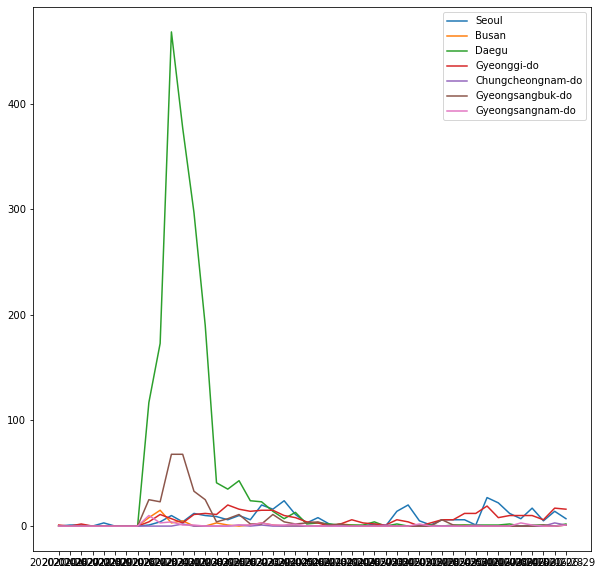

In [44]:
pv_li_idx = [0, 1, 2, 8, 13, 14, 15 ]
pv_li_nam = ['Seoul','Busan', 'Daegu', 'Gyeonggi-do','Chungcheongnam-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do']

for i,j in zip(pv_li_idx, pv_li_nam):
    s = globals()['p_wknd_{}'.format(i)]
    plt.plot(s['date'],s['daily'], label = j)
    plt.legend()
plt.show()

> **비대면 수업**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn') 

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# 한글 폰트 적용
plt.rc('font', family='NanumBarunGothic') 
# 캔버스 사이즈 적용
plt.rcParams["figure.figsize"] = (12, 9)


In [3]:
case = pd.read_csv('./dataset/Case.csv')
time = pd.read_csv('./dataset/Time.csv')
timeage = pd.read_csv('./dataset/TimeAge.csv')
region = pd.read_csv('./dataset/Region.csv')
policy = pd.read_csv('./dataset/Policy.csv')
painfo = pd.read_csv('./dataset/PatientInfo.csv')

In [4]:
timeage.head()

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1


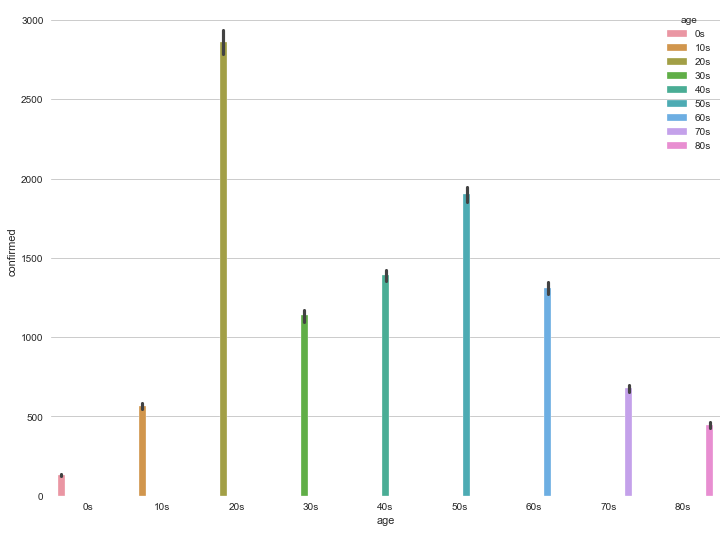

In [5]:
# 차트 배경 설정
sns.set_style('whitegrid')
# 차트 세로로 그리기
sns.barplot(x="age",y="confirmed", hue="age", data=timeage)
plt.show()

In [6]:
timeage.astype({'confirmed':'int'})

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1
...,...,...,...,...,...
1084,2020-06-30,0,40s,1681,3
1085,2020-06-30,0,50s,2286,15
1086,2020-06-30,0,60s,1668,41
1087,2020-06-30,0,70s,850,82


In [7]:
age = ['0s','10s','20s','30s','40s','50s','60s','70s','80s']

In [8]:
tem = []
for i in age:
    con = timeage.age == i
    i=timeage[con]
    i['daily'] = i['confirmed'].diff().fillna(0)
    tem.append(i['daily'].sum())

print(tem)

[161.0, 539.0, 2127.0, 990.0, 1048.0, 1452.0, 1138.0, 658.0, 475.0]


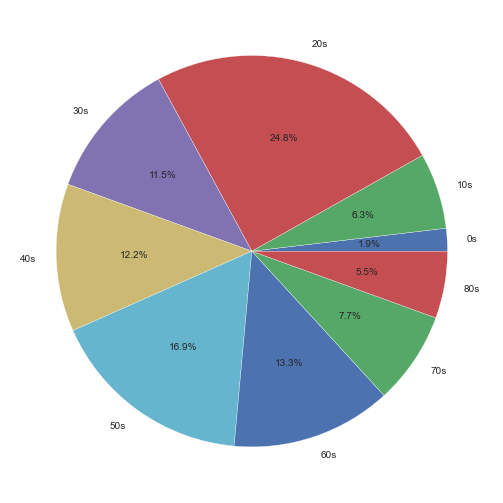

In [9]:
ratio = tem
labels = ['0s','10s','20s','30s','40s','50s','60s','70s','80s']

plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

In [10]:
timeage.isnull()

,date,time,age,confirmed,deceased
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
1084,False,False,False,False,False
1085,False,False,False,False,False
1086,False,False,False,False,False
1087,False,False,False,False,False


In [11]:
# timeage 데이터에서 time과 deceased 데이터는 우선 제거 한다.
timeage = timeage.drop('time',axis=1)
timeage = timeage.drop('deceased',axis=1)
timeage

,date,age,confirmed
0,2020-03-02,0s,32
1,2020-03-02,10s,169
2,2020-03-02,20s,1235
3,2020-03-02,30s,506
4,2020-03-02,40s,633
...,...,...,...
1084,2020-06-30,40s,1681
1085,2020-06-30,50s,2286
1086,2020-06-30,60s,1668
1087,2020-06-30,70s,850


In [12]:
# 나이대별 분포를 확인하기 위한 변수 생성
s10 = timeage['age'] == '10s'
s20 = timeage['age'] == '20s'
s40 = timeage['age'] == '40s'
s50 = timeage['age'] == '50s'

In [13]:
s10 = timeage[s10]
s20 = timeage[s20]
s40 = timeage[s40]
s50 = timeage[s50]

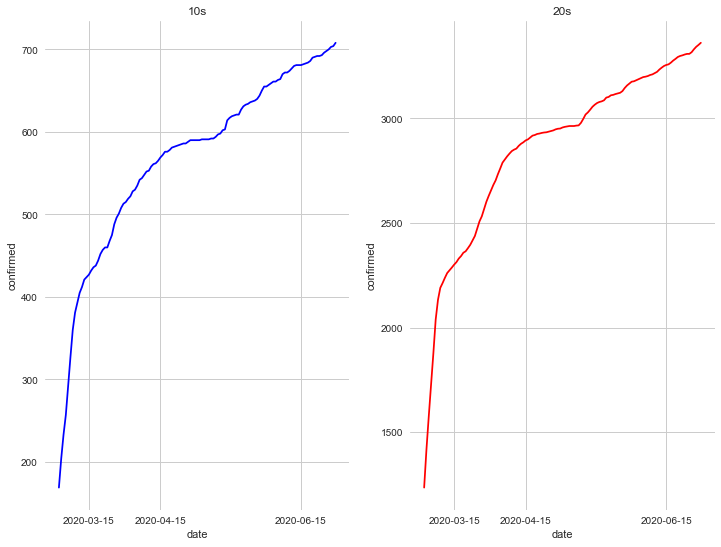

In [14]:
plt.subplot(121)
plt.plot(s10['date'],s10['confirmed'],c="b")
plt.title("10s")
plt.xlabel('date')
plt.ylabel('confirmed')
plt.xticks(['2020-03-15','2020-04-15', '2020-06-15'])

plt.subplot(122)
plt.plot(s20['date'],s20['confirmed'],c="r")
plt.title("20s")
plt.xlabel('date')
plt.ylabel('confirmed')
plt.xticks(['2020-03-15','2020-04-15', '2020-06-15'])


plt.show()

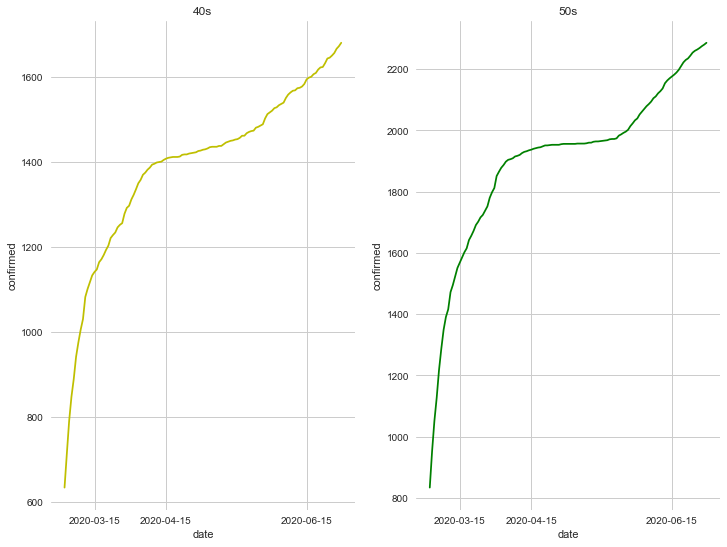

In [15]:
plt.subplot(121)
plt.plot(s40['date'],s40['confirmed'],c="y")
plt.title("40s")
plt.xlabel('date')
plt.ylabel('confirmed')
plt.xticks(['2020-03-15','2020-04-15', '2020-06-15'])

plt.subplot(122)
plt.plot(s50['date'],s50['confirmed'],c="g")
plt.title("50s")
plt.xlabel('date')
plt.ylabel('confirmed')
plt.xticks(['2020-03-15','2020-04-15', '2020-06-15'])

plt.show()

([<matplotlib.axis.XTick at 0x26d88d0d6a0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

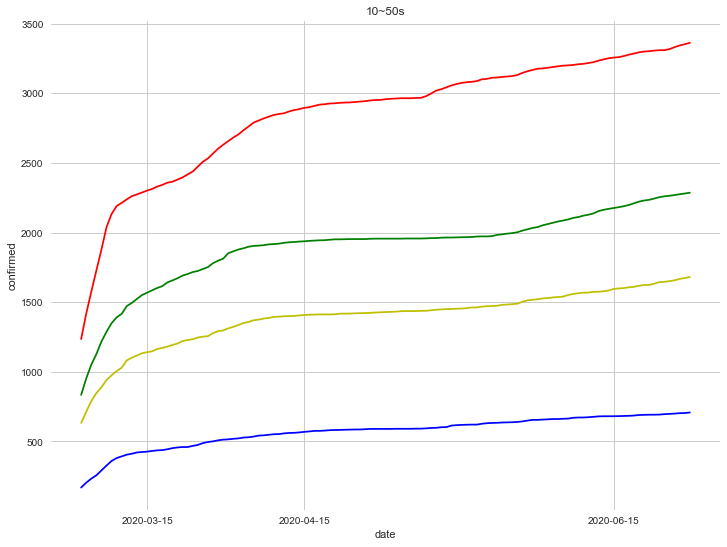

In [16]:
plt.title("10~50s")
plt.xlabel('date')
plt.ylabel('confirmed')
plt.plot(s10['date'],s10['confirmed'],c="b",label="10s")
plt.plot(s20['date'],s20['confirmed'],c="r",label="20s")
plt.plot(s40['date'],s40['confirmed'],c="y",label="40s")
plt.plot(s50['date'],s50['confirmed'],c="g",label="50s")
plt.xticks(['2020-03-15','2020-04-15', '2020-06-15'])

In [17]:
policy.head(25)

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,NaN
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,NaN
5,6,Korea,Immigration,Special Immigration Procedure,from Hong Kong,2020-02-12,NaN
6,7,Korea,Immigration,Special Immigration Procedure,from Macau,2020-02-12,NaN
7,8,Korea,Immigration,Special Immigration Procedure,from Japan,2020-03-09,NaN
8,9,Korea,Immigration,Special Immigration Procedure,from Italy,2020-03-12,NaN
9,10,Korea,Immigration,Special Immigration Procedure,from Iran,2020-03-12,NaN


In [18]:
pol_con = policy['type']=='Education'
pol_con

0     False
1     False
2     False
3     False
4     False
      ...  
56    False
57    False
58    False
59    False
60    False
Name: type, Length: 61, dtype: bool

In [19]:
policy[pol_con].head(15)

,policy_id,country,type,gov_policy,detail,start_date,end_date
33,34,Korea,Education,School Closure,Daycare Center for Children,2020-03-02,NaN
34,35,Korea,Education,School Opening Delay,Kindergarten,2020-03-02,2020-04-06
35,36,Korea,Education,School Opening Delay,High School,2020-03-02,2020-04-06
36,37,Korea,Education,School Opening Delay,Middle School,2020-03-02,2020-04-06
37,38,Korea,Education,School Opening Delay,Elementary School,2020-03-02,2020-04-06
38,39,Korea,Education,School Opening with Online Class,High School (3rd grade),2020-04-09,2020-05-20
39,40,Korea,Education,School Opening with Online Class,High School (2nd grade),2020-04-16,2020-05-27
40,41,Korea,Education,School Opening with Online Class,High School (1st grade),2020-04-16,2020-06-03
41,42,Korea,Education,School Opening with Online Class,Middle School (3rd grade),2020-04-09,2020-05-27
42,43,Korea,Education,School Opening with Online Class,Middle School (2nd grade),2020-04-16,2020-06-03


In [20]:
# 학교 입학 지연이 School Closure로 표현되고 무기한으로 나타나 있어서 NaN값을 제거한다.
policy[pol_con].dropna()

,policy_id,country,type,gov_policy,detail,start_date,end_date
34,35,Korea,Education,School Opening Delay,Kindergarten,2020-03-02,2020-04-06
35,36,Korea,Education,School Opening Delay,High School,2020-03-02,2020-04-06
36,37,Korea,Education,School Opening Delay,Middle School,2020-03-02,2020-04-06
37,38,Korea,Education,School Opening Delay,Elementary School,2020-03-02,2020-04-06
38,39,Korea,Education,School Opening with Online Class,High School (3rd grade),2020-04-09,2020-05-20
39,40,Korea,Education,School Opening with Online Class,High School (2nd grade),2020-04-16,2020-05-27
40,41,Korea,Education,School Opening with Online Class,High School (1st grade),2020-04-16,2020-06-03
41,42,Korea,Education,School Opening with Online Class,Middle School (3rd grade),2020-04-09,2020-05-27
42,43,Korea,Education,School Opening with Online Class,Middle School (2nd grade),2020-04-16,2020-06-03
43,44,Korea,Education,School Opening with Online Class,Middle School (1st grade),2020-04-16,2020-06-08


총 14개의 정책이 시행 됐는데 비대면 수업만을 생각하면   
4월 9일  
4월 16일  
4월 20일  
이 세 날짜로 나눌수 있다.   

([<matplotlib.axis.XTick at 0x26d893613d0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

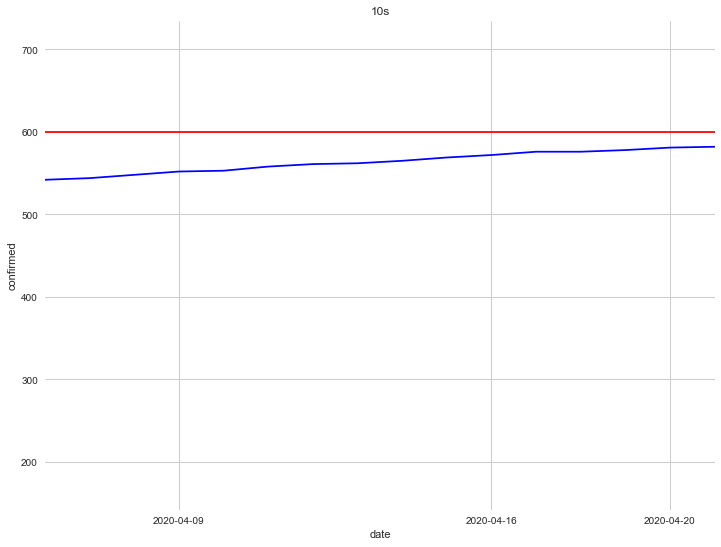

In [21]:
plt.title("10s")
plt.xlabel('date')
plt.ylabel('confirmed')
plt.plot(s10['date'],s10['confirmed'],c="b",label="10s")
plt.plot(s10['date'],[600]*len(s10['date']),c="r")
plt.xlim([35, 50])

plt.xticks(['2020-04-09','2020-04-16', '2020-04-20'])

기울기가 점차 감소함은 가시적으로 확인 가능하다! <br>   
그러나 확실하게 유의미한 값인지는 좀 더 세부적으로 일일 감염자 수 증가를 통해 판단 해야 할것 같다.<br>

In [22]:
li = [s10, s20, s40, s50]
for i in li:
    i = i.astype({'confirmed':'int'})
# s10 = s10.astype({'confirmed':'int'})

In [23]:
# 일일 확진자수
for i in li:
    i['daily'] = i['confirmed'].diff().fillna(0)
# s10['daily'] = s10['confirmed'].diff().fillna(0)
s10

,date,age,confirmed,daily
1,2020-03-02,10s,169,0.0
10,2020-03-03,10s,204,35.0
19,2020-03-04,10s,233,29.0
28,2020-03-05,10s,257,24.0
37,2020-03-06,10s,292,35.0
...,...,...,...,...
1045,2020-06-26,10s,698,2.0
1054,2020-06-27,10s,700,2.0
1063,2020-06-28,10s,703,3.0
1072,2020-06-29,10s,704,1.0


([<matplotlib.axis.XTick at 0x26d89555e50>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

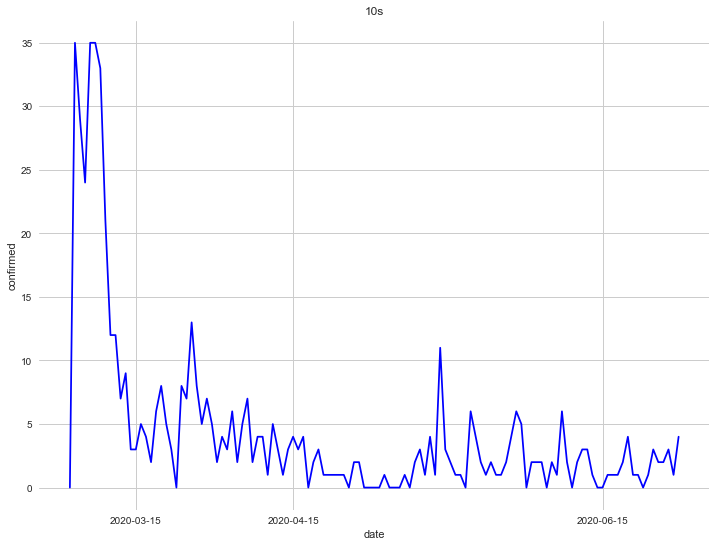

In [24]:
#일일 확진자 별 그래프
plt.title("10s")
plt.xlabel('date')
plt.ylabel('confirmed')
plt.plot(s10['date'],s10['daily'],c="b",label="10s")
plt.xticks(['2020-03-15','2020-04-15', '2020-06-15'])
# plt.xlim([35, 50])

(20.0, 50.0)

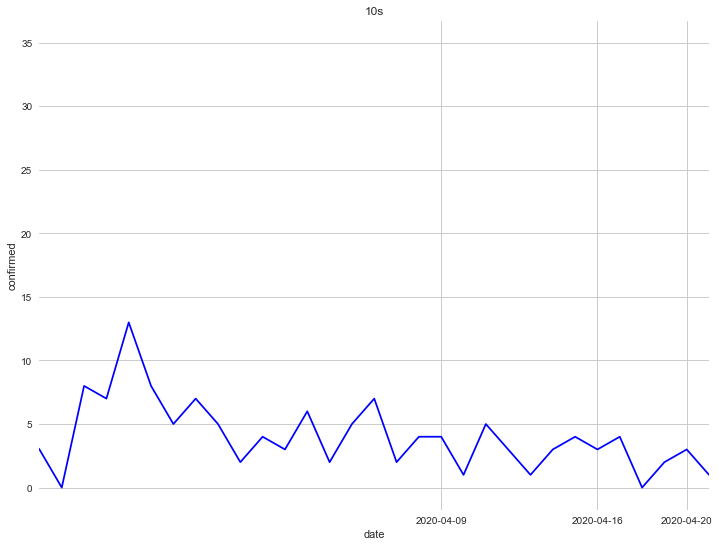

In [25]:
#일일 확진자 별 그래프
plt.title("10s")
plt.xlabel('date')
plt.ylabel('confirmed')
plt.plot(s10['date'],s10['daily'],c="b",label="10s")
plt.xticks(['2020-04-09','2020-04-16', '2020-04-20'])
plt.xlim([20, 50])

유의미한 값으로 보이지 않아 기울기를 통해 유효성을 체크 해보도록 하겠습니다.

In [26]:
s10.iloc[35]

date         2020-04-06
age                 10s
confirmed           542
daily               7.0
Name: 316, dtype: object

In [27]:
# 위 그래프를 참고해서 4월 7일 전,후로 평균 값을 구한다.
a = (sum(s10.iloc[20:25]['daily'])/5 - s10.iloc[35]['daily'])/15
b = (s10.iloc[35]['daily'] - sum(s10.iloc[50:55]['daily'])/5)/15
print(a)
print(b)

-0.05333333333333332
0.4


(20.0, 50.0)

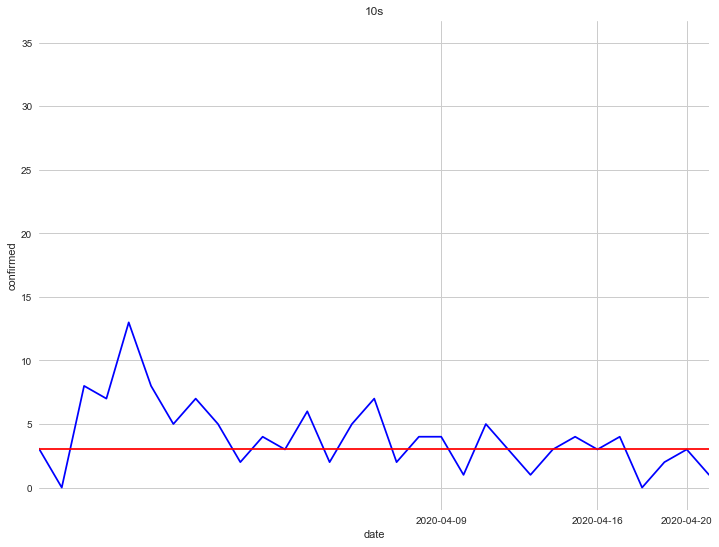

In [28]:
plt.title("10s")
plt.xlabel('date')
plt.ylabel('confirmed')
plt.plot(s10['date'],s10['daily'],c="b",label="10s")
plt.plot(s10['date'],[3]*len(s10['date']),c="r")
plt.xticks(['2020-04-09','2020-04-16', '2020-04-20'])
plt.xlim([20, 50])

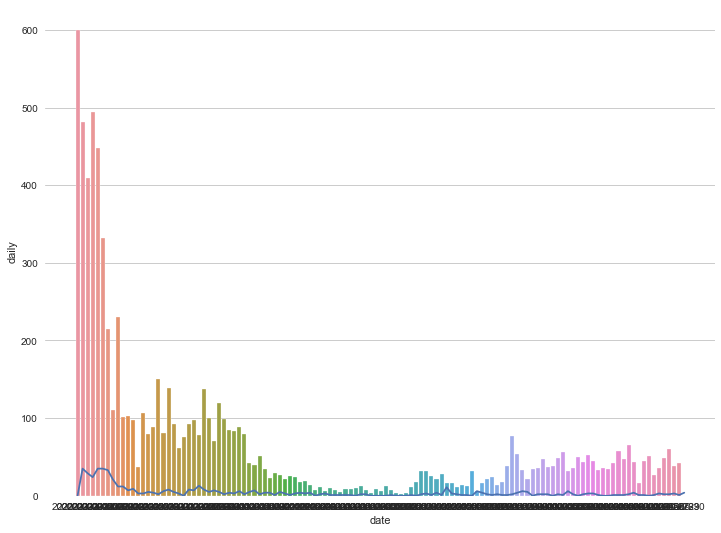

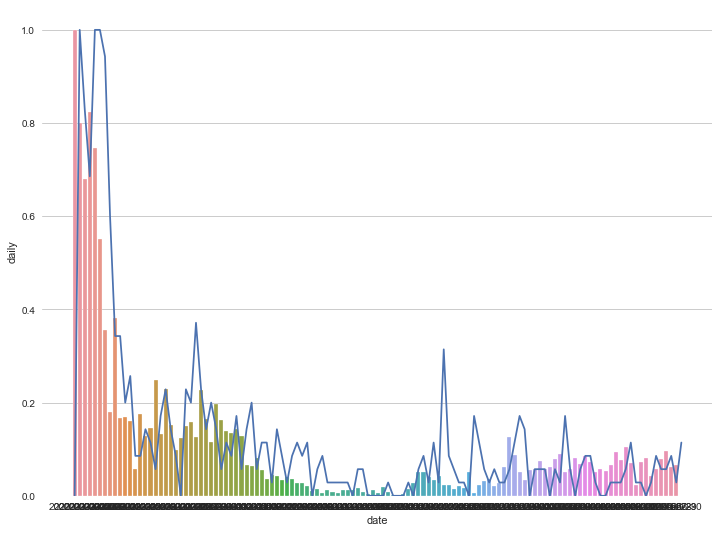

In [29]:
time = pd.read_csv('./dataset/Time.csv')
time['daily'] = time['confirmed'].diff().fillna(0)

time = time[43:]
time.index = [i for i in range(len(time))]
s10.index = [i for i in range(len(s10))]

time['daily'] = time['daily']- s10['daily']

# 차트 배경 설정
sns.set_style('whitegrid')
# 차트 세로로 그리기
sns.barplot(x="date",y="daily", data=time) # hue="age"
sns.lineplot(x="date",y="daily", data=s10) # hue="age"
plt.show()

# 데이터 정규화
'''
s10 min : 0, max : 35
time min : 2, max : 600
'''
# s10 정규화
s10['daily'] = (s10['daily']-0)/35
time['daily'] = (time['daily']-2)/598

# 차트 배경 설정
sns.set_style('whitegrid')
# 차트 세로로 그리기
sns.barplot(x="date",y="daily", data=time) # hue="age"
sns.lineplot(x="date",y="daily", data=s10) # hue="age"
plt.show()

> **드라이브 스루**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) 

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
case = pd.read_csv('./dataset/Case.csv')
time = pd.read_csv('./dataset/Time.csv',index_col=0, parse_dates=True)
timeage = pd.read_csv('./dataset/TimeAge.csv')
region = pd.read_csv('./dataset/Region.csv')
policy = pd.read_csv('./dataset/Policy.csv')
painfo = pd.read_csv('./dataset/PatientInfo.csv')

## 결측값 처리

In [3]:
pol = policy.fillna('2020-12-31') # 결측값을 '2020-12-31'으로 처리
pol

,policy_id,country,type,gov_policy,detail,start_date,end_date
0,1,Korea,Alert,Infectious Disease Alert Level,Level 1 (Blue),2020-01-03,2020-01-19
1,2,Korea,Alert,Infectious Disease Alert Level,Level 2 (Yellow),2020-01-20,2020-01-27
2,3,Korea,Alert,Infectious Disease Alert Level,Level 3 (Orange),2020-01-28,2020-02-22
3,4,Korea,Alert,Infectious Disease Alert Level,Level 4 (Red),2020-02-23,2020-12-31
4,5,Korea,Immigration,Special Immigration Procedure,from China,2020-02-04,2020-12-31
...,...,...,...,...,...,...,...
56,57,Korea,Transformation,Logistics center,On-site inspection of major logistics faciliti...,2020-05-29,2020-06-11
57,58,Korea,Transformation,Wearing of masks,"Mandatory wearing of passenger mask domestic, ...",2020-05-27,2020-12-31
58,59,Korea,Transformation,Wearing of masks,Drivers such as buses and taxis can refuse to ...,2020-05-26,2020-12-31
59,60,Korea,Technology,KI-Pass: Korea Internet - Pass,new quick response (QR) code system this week ...,2020-06-10,2020-12-31


In [4]:
time = time.fillna('0') # 결측값을 0으로 처리
time

,time,test,negative,confirmed,released,deceased
date,,,,,,
2020-01-20,16,1,0,1,0,0
2020-01-21,16,1,0,1,0,0
2020-01-22,16,4,3,1,0,0
2020-01-23,16,22,21,1,0,0
2020-01-24,16,27,25,2,0,0
...,...,...,...,...,...,...
2020-06-26,0,1232315,1200885,12602,11172,282
2020-06-27,0,1243780,1211261,12653,11317,282
2020-06-28,0,1251695,1219975,12715,11364,282


## 시각화
드라이브 스루 정책 시행일 2020년 2월 26일 기준으로 검사자가 얼마나 증가했는지 그래프로 확인하는 과정

- - -
### 일일 검사자 수 
2020년 2월 26일 정책 시행 당일 검사수 **53553건**에서 해당 데이터의 마지막 날인 2020년 6월 30일 **1273766건**으로 기하급수적인 증가세를 확인할 수 있다.

In [5]:
# 일일 검사자 수
daily = time.astype({'test':'int'})
daily['daily'] = daily['test'].diff().fillna(0)
daily = daily.reset_index().rename(columns = {'index':'date'})
daily

,date,time,test,negative,confirmed,released,deceased,daily
0,2020-01-20,16,1,0,1,0,0,0.0
1,2020-01-21,16,1,0,1,0,0,0.0
2,2020-01-22,16,4,3,1,0,0,3.0
3,2020-01-23,16,22,21,1,0,0,18.0
4,2020-01-24,16,27,25,2,0,0,5.0
...,...,...,...,...,...,...,...,...
158,2020-06-26,0,1232315,1200885,12602,11172,282,11837.0
159,2020-06-27,0,1243780,1211261,12653,11317,282,11465.0
160,2020-06-28,0,1251695,1219975,12715,11364,282,7915.0
161,2020-06-29,0,1259954,1228698,12757,11429,282,8259.0


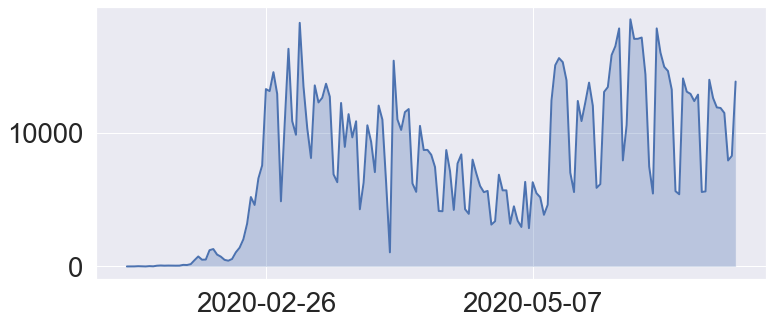

In [16]:
fig1, ax1 = plt.subplots()
plt.rcParams["figure.figsize"] = (12,5)
plt.plot(daily['date'],daily['daily'], linewidth = 2.0)
# plt.bar(daily['date'],daily['daily'], width = 1.0, alpha = 0.2)
plt.fill_between(daily['date'],daily['daily'],alpha = 0.3)
plt.xticks(['2020-02-26','2020-05-07'])

plt.show()

In [7]:
time = time.reset_index().rename(columns = {'index':'date'})
time.head()

,date,time,test,negative,confirmed,released,deceased
0,2020-01-20,16,1,0,1,0,0
1,2020-01-21,16,1,0,1,0,0
2,2020-01-22,16,4,3,1,0,0
3,2020-01-23,16,22,21,1,0,0
4,2020-01-24,16,27,25,2,0,0


- - -
### 누적 검사자수
2020년 2월 26일 정책 시행 당일 검사수 **53553건**에서 해당 데이터의 마지막 날인 2020년 6월 30일 **1273766건**으로 기하급수적인 증가세를 확인할 수 있다.

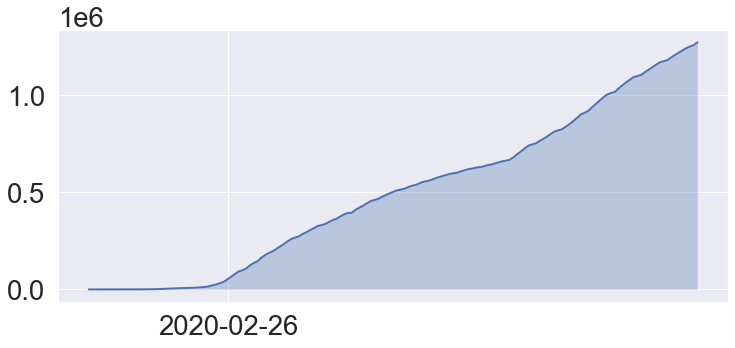

In [8]:
fig2, ax2 = plt.subplots()
plt.rcParams["figure.figsize"] = (12,5)
plt.plot(time['date'],time['test'], linewidth = 2.0)
# plt.bar(daily['date'],daily['daily'], width = 1.0, alpha = 0.2)
plt.fill_between(time['date'],time['test'],alpha = 0.3)
plt.xticks(['2020-02-26'])



plt.show()